In [43]:
%load_ext autoreload
%autoreload 2
from src.generator.generator import Generator
from PIL import Image
from src.face_frame import face_frame_correction
import torch
from src.nets.MobileNetV2_unet import MobileNetV2_unet
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import src.face_frame as face_frame

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
gen = Generator("https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhqu-256x256.pkl")

In [45]:
target_pil = Image.open("/app/ref.png")
target_pil = target_pil.convert('RGB')
output = Image.open("/app/ref.png")
output = output.convert('RGB')

In [46]:
model = MobileNetV2_unet(None).to(torch.device("cuda"))
state_dict = torch.load('./src/checkpoints/model.pt', map_location='cuda')
model.load_state_dict(state_dict)
model.eval()
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [85]:
ws = face_frame_correction(target_pil, None, gen.G, gen.device)

step    1/300: dist 6224.00 loss 12.40
step    5/300: dist 5599.00 loss 11.16
step   59/300: dist 5078.00 loss 10.12
step   65/300: dist 4988.00 loss 9.94 


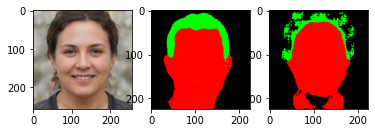

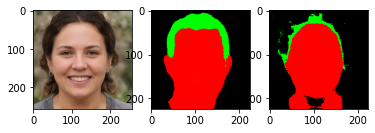

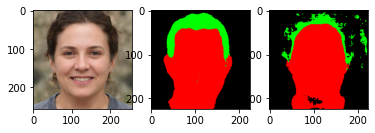

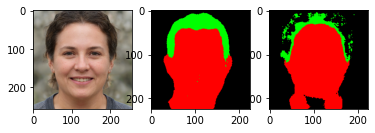

In [86]:
target_mask = face_frame.create_segmentation_mask(model, target_pil)
def plot_mask(mask):
    mask = mask.squeeze(0)
    colors = np.array([[0, 0, 0], [255, 0, 0], [0, 255, 0]])
    mask = mask.cpu().numpy()
    mask = colors[mask]
    plt.imshow(mask)
for w in ws:
    
    #plot image
    plt.subplot(1, 3, 1)
    _w = w.unsqueeze(0)
    img_gen = gen.G.synthesis(_w, noise_mode='const')
    img = (img_gen.permute(0, 2, 3, 1) * 127.5 +
                    128).clamp(0, 255).to(torch.uint8)
    img = img[0].cpu().numpy()
    plt.imshow(img)
    plt.subplot(1, 3, 2)
    #plot target mask
    plot_mask(target_mask)
    plt.subplot(1, 3, 3)
    mask = face_frame.create_segmentation_mask_from_network(model, img_gen)
    plot_mask(mask)

    plt.show()